## This script introduces vectorized geometry definition

#### Import python package 

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.style.use("dark_background")
plt.rcParams['image.cmap'] = 'gray'

#### Import CTorch package 

In [2]:
import CTorch.utils.geometry as geometry
from CTorch.projector.projector_interface import Projector
from CTorch.reconstructor.fbpreconstructor import FBPReconstructor  as FBP

#### Define [geometry](./2_geometry.ipynb)

Here we take 2D geometry as an example, fbp with 3D geoemtry can be done in the same way

In [3]:
nx, ny = 512,512 # image dimension
dx, dy = 0.8, 0.8 # image pixel size

nu = 1024 # detector length 
du = 1.0 # detecor pixel size
nView = 720 # number of views
viewAngles = np.arange(0,-2*np.pi,-2*np.pi/nView) # projection angle
detType = 'curve' #'curve'
SAD, SDD = [800.0], [1200.0] # source-axis-distance, source-detector-distance

xOfst, yOfst = [0.0], [0.0] # image center offset
uOfst = [0.0] # detecor center offset
xSrc = [0.0]

# define static geometry
geoms = geometry.Geom2D(nx, ny, dx, dy, nu, nView, viewAngles, du, detType, SAD, SDD, 
                 xOfst = xOfst, yOfst = yOfst, uOfst = uOfst, xSrc = xSrc, fixed=True)  


In [ ]:
xOfst, yOfst = torch.randn(nView,dtype=torch.float32), torch.randn(nView,dtype=torch.float32) # image center offset
uOfst = torch.randn(nView,dtype=torch.float32)
xSrc = torch.randn(nView,dtype=torch.float32)

# define vectorized (view-specific) geometry
geomv = geometry.Geom2D(nx, ny, dx, dy, nu, nView, viewAngles, du, detType, SAD, SDD, 
                 xOfst = xOfst, yOfst = yOfst, uOfst = uOfst, xSrc = xSrc, fixed=False) 

#### Define [projector](3_projector.ipynb) and reconstructor

In [5]:
projAlgo = 'SF' 
reconAlgo = 'SF' 
A = Projector(geomv,'proj', projAlgo,'forward') # simualtion with vectorized geometry
Recons = FBP(geoms, reconAlgo, window="hamming", cutoff=0.95) # reconstruction with static geometry
Reconv = FBP(geomv, reconAlgo, window="hamming", cutoff=0.95) # reconstruction with vectorized geometry

#### Load example data

In [6]:
batch_size = 32 # number of images per batch
channel_size = 3 # number of image channels

img = io.loadmat("img_example.mat")["img"]
img = torch.Tensor(img).reshape([1,1,ny,nx]).cuda()
img = img.repeat(batch_size, channel_size, 1, 1)

In [7]:
img[0,0,256,256]

tensor(0.0230, device='cuda:0')

#### Execute sinogram simulation and FBP reconstruction

**NOTE**: If batch_size and channel_size is not 1, all the batches and channels will be reconstructed simultaneously.

In [8]:
sino = A(img)
imgs = Recons(sino)
imgv = Reconv(sino)

#### Display results

In [9]:
sino = sino.squeeze().cpu().detach().numpy()
imgs = imgs.squeeze().cpu().detach().numpy()
imgv = imgv.squeeze().cpu().detach().numpy()
img = img.squeeze().cpu().detach().numpy()

Text(0.5, 1.0, 'From left to right: recon with static geometry, vectorzied geometry, ground truth')

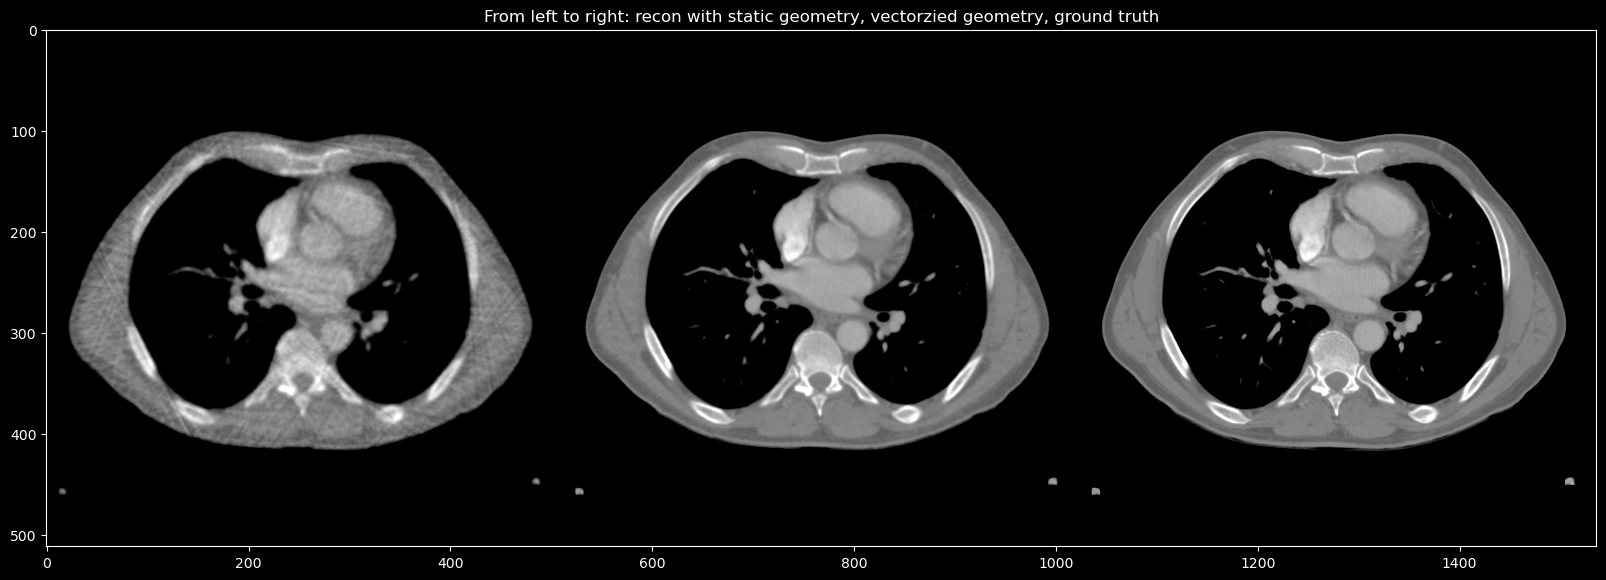

In [10]:
plt.figure(figsize=(20, 20))
plt.imshow(np.hstack((imgs[0,0],imgv[1,1],img[0,0])),vmin = 0.01,vmax=0.03)
plt.title('From left to right: recon with static geometry, vectorzied geometry, ground truth')